In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class PositionalEncoding(layers.Layer):
    def __init__(self, input_size, hidden_size):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self._get_positional_encoding(input_size, hidden_size)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

    def _get_positional_encoding(self, input_size, hidden_size):
        angle_rads = self._get_angles(input_size, hidden_size)

        # Apply sin to even indices in the array
        angle_rads[:, 0::2] = tf.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array
        angle_rads[:, 1::2] = tf.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def _get_angles(self, input_size, hidden_size):
        positions = np.arange(input_size)[:, np.newaxis]
        indices = np.arange(hidden_size)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (indices // 2)) / np.float32(hidden_size))
        return positions * angle_rates


class TransformerLayer(layers.Layer):
    def __init__(self, hidden_size, num_heads):
        super(TransformerLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads, hidden_size)
        self.dropout = layers.Dropout(0.1)
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential(
            [layers.Dense(hidden_size, activation="relu"), layers.Dense(hidden_size)]
        )

    def call(self, x, training):
        # Attention
        attn_output = self.mha(x, x, training=training)
        attn_output = self.dropout(attn_output, training=training)
        res = self.norm(x + attn_output)
        # Feed Forward
        ffn_output = self.ffn(res)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.norm(res + ffn_output)


class Transformer(tf.keras.Model):
    def __init__(self, input_size, hidden_size, num_layers, num_heads):
        super(Transformer, self).__init__()

        self.embedding = layers.Embedding(input_size, hidden_size)
        self.pos_encoding = PositionalEncoding(input_size, hidden_size)
        self.decoder = [TransformerLayer(hidden_size, num_heads) for _ in range(num_layers)]
        self.output_layer = layers.Dense(input_size)

    def call(self, x, training=True):
        x = self.embedding(x)
        x = self.pos_encoding(x)

        for decoder_layer in self.decoder:
            x = decoder_layer(x, training)

        output = self.output_layer(x)

        return output


In [2]:
import random

# Hyperparameters
input_size = 50  # Example: Range of input numbers
hidden_size = 64
num_layers = 2
num_heads = 4
learning_rate = 0.001
num_epochs = 500

# Define the loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Create the transformer model
model = Transformer(input_size, hidden_size, num_layers, num_heads)


In [14]:
n = random.randint(2,10) # Define the length of your lists
start = random.uniform(0, input_size - 21)  # Start with a random integer
training_data = [start + 2*i for i in range(n)]
training_data

[7.392128069293612,
 9.392128069293612,
 11.392128069293612,
 13.392128069293612,
 15.392128069293612,
 17.392128069293612,
 19.392128069293612,
 21.392128069293612,
 23.392128069293612]

In [20]:
type(training_data)

list

In [4]:
N = 10  # Number of classes
target_values = [int(x) % N + 1 for x in training_data]
target_values

[4, 6, 8, 10, 2, 4]

In [17]:
data = tf.constant([training_data])
tgt = tf.constant([target_values])

In [18]:
type(data)

tensorflow.python.framework.ops.EagerTensor

In [19]:
data

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 7.392128,  9.392128, 11.392128, 13.392128, 15.392128, 17.392128,
        19.392128, 21.392128, 23.392128]], dtype=float32)>

In [9]:
tgt

<tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 4,  6,  8, 10,  2,  4]], dtype=int32)>

In [3]:
import matplotlib.pyplot as plt

# Lists to store the loss values and epochs
loss_history = []
epoch_history = []

# Training loop
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:

        # here we make the training data, we generate a sequence of random numbers as coordintes of hits
        # and then we below we assign classes to those numbers
        n = random.randint(2,10) # Define the length of your lists
        start = random.uniform(0, input_size - 21)  # Start with a random integer
        training_data = [start + 2*i for i in range(n)]

        # the target values are just classes, computed with the modulo from the coordinates that are the inputs
        #target_values = [x + 2 for x in training_data]
        N = 10  # Number of classes
        target_values = [int(x) % N + 1 for x in training_data]
    
#        n = 10-1  # Define the length of your lists
#        start = random.randint(0, input_size - 3)  # Start with a random integer
#        training_data = [start + 2*i for i in range(n)]
#        target_values = [x + 2 for x in training_data]
        
        # Convert training data to tensors
        data = tf.constant([training_data])
        tgt = tf.constant([target_values])

        # Reset the initial prediction value for each epoch
        #tgt_input = tgt[:, :-1]  # Exclude last target value during training
        #real_tgt = tgt[:, 1:]    # Calculate loss with target shifted by one

        # Forward pass
        #output = model(tgt_input, training=True)
        output = model(data, training=True)

        # Calculate loss
        loss = loss_function(tgt, output)
        # Append the loss and epoch to the history lists
        loss_history.append(loss.numpy())
        epoch_history.append(epoch)

        if epoch % 50 == 0 or epoch == (num_epochs-1):
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.numpy():.4f}")
            print (training_data)
            print (target_values)


    # Perform gradient descent
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Epoch [0/500], Loss: 2.9928
[0.3220419607359972, 2.322041960735997, 4.322041960735997, 6.322041960735997]
[1, 3, 5, 7]
Epoch [50/500], Loss: 1.9694
[13.988286370683527, 15.988286370683527, 17.988286370683525, 19.988286370683525, 21.988286370683525, 23.988286370683525, 25.988286370683525, 27.988286370683525, 29.988286370683525, 31.988286370683525]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
Epoch [100/500], Loss: 2.6252
[12.565846020900484, 14.565846020900484, 16.565846020900484, 18.565846020900484, 20.565846020900484, 22.565846020900484]
[3, 5, 7, 9, 1, 3]
Epoch [150/500], Loss: 2.4866
[21.482893462361062, 23.482893462361062, 25.482893462361062, 27.482893462361062, 29.482893462361062, 31.482893462361062]
[2, 4, 6, 8, 10, 2]
Epoch [200/500], Loss: 2.3017
[25.993386700931993, 27.993386700931993, 29.993386700931993, 31.993386700931993, 33.99338670093199, 35.99338670093199, 37.99338670093199, 39.99338670093199, 41.99338670093199]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
Epoch [250/500], Loss: 1.3027
[5.93221706

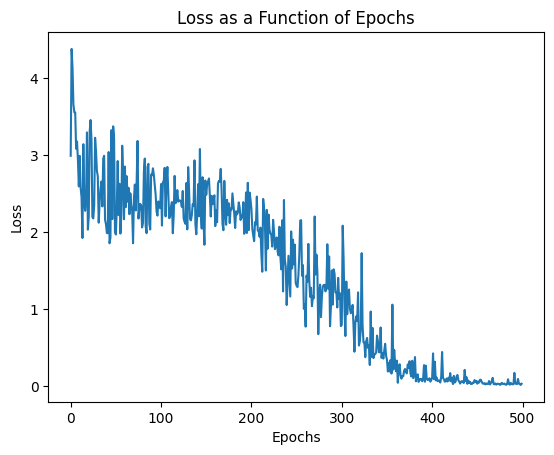

In [4]:
# Plot the loss history
plt.plot(epoch_history, loss_history)
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [5]:
model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  3200      
                                                                 
 positional_encoding (Positi  multiple                 0         
 onalEncoding)                                                   
                                                                 
 transformer_layer (Transfor  multiple                 74816     
 merLayer)                                                       
                                                                 
 transformer_layer_1 (Transf  multiple                 74816     
 ormerLayer)                                                     
                                                                 
 dense_4 (Dense)             multiple                  3250      
                                                       

In [6]:
# Example test data
test_data = [9]
test_input = tf.constant([test_data])
print(test_input)
print(test_input[:, :-1])


tf.Tensor([[9]], shape=(1, 1), dtype=int32)
tf.Tensor([], shape=(1, 0), dtype=int32)


In [7]:
# Make predictions
predictions = model(test_input, training=False)


In [8]:
print (predictions)

tf.Tensor(
[[[-1.025277   -3.3409045   1.168122   -0.06233371  1.9726312
    0.7708724   4.872664   -0.39810374  2.1897993  -1.2321839
    5.227228   -3.5191116  -2.1916342  -1.3772986  -1.2910961
   -3.5854783  -2.7429576  -2.1395562  -2.6973407  -2.3342965
   -4.568336   -2.4132078  -3.5768075  -1.457867   -3.5987823
   -2.8354876  -2.4985838  -2.7464073  -3.4241416  -2.477642
   -3.901896   -3.2484565  -3.1460493  -2.8146036  -2.9578035
   -2.7951584  -2.847752   -1.692033   -2.317044   -3.0975819
   -1.8060217  -1.0394047  -3.2430067  -1.9018011  -1.2141824
   -2.1012678  -2.4103317  -2.1254272  -3.5907078  -2.7591968 ]]], shape=(1, 1, 50), dtype=float32)


In [9]:
# Print the predicted values
predicted_values = tf.argmax(predictions[:, -1, :], axis=-1).numpy().tolist()
print (predicted_values)
for i, prediction in enumerate(predicted_values):
    print(f"Predicted class for number {test_data[i]} is : {prediction}")


[10]
Predicted class for number 9 is : 10


import pandas as pd

# Read the CSV file
df = pd.read_csv('/Users/saschacaron/Downloads/experiment_2d_noisy-1-to-20-tracks/events_all/hits_and_tracks_2d_events_all.csv')

# Print the contents of the DataFrame
print(df.head())
